In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/danmuir/Projects/tbfm_multisession/data"
sys.path.append(DATA_DIR)
# imported from JNE project
from tbfm import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

In [2]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"]
# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
held_in_session_ids = ["MonkeyJ_20160426_Session2_S1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

try:
    num_sessions = len(held_in_session_ids)
except NameError:
    num_sessions = 25

# XXX remove
num_sessions = 40
batch_size = 25000# // 40
    
# MAX_BATCH_SIZE = 62500 // 2
# batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    # held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=0#NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [15]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
Test
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])
torch.Size([625, 20, 93])


In [16]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"

def cfg_big_bases(cfg):
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 100
    cfg.tbfm.module.latent_dim = 3
    cfg.training.epochs = 12001
    cfg.latent_dim = 74
    cfg.ae.use_two_stage = False
    cfg.ae.training.lambda_ae_recon = 0.03
    cfg.tbfm.training.lambda_fro = 60.0

    
cfg.training.epochs = 12001
cfg.latent_dim = 85
cfg.tbfm.module.num_bases = 60
cfg.ae.training.lambda_ae_recon = 0.03
cfg.ae.use_two_stage = False
cfg.ae.two_stage.freeze_only_shared = False
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 75.0

cfg.meta.is_basis_residual = True
cfg.meta.basis_residual_rank = 16
cfg.meta.training.lambda_l2 = 1e-2

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Current runs:
#  * Koopman GPU 0/1: larger basis count
#  * Kalman GPU 0: 25 sessions, 60 bases, basis_residual_rank = 32

---- 0 1.422231674194336 0.8514220714569092 0.5598085522651672 0.6200730800628662


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)

---- 0 0.7086216807365417 1.7141916453838348 -0.08964778463123366 -0.11116867139935493
---- 1000 0.43093082308769226 1.196054220199585 0.34567207332438554 0.3437837213277817
---- 2000 0.4178732931613922 1.2506276369094849 0.3630286410450935 0.35466382652521133
---- 3000 0.4037984013557434 1.2719065994024277 0.3840659871697426 0.3707411289215088
---- 4000 0.39447858929634094 1.2901018410921097 0.39810558119788764 0.38002119958400726
---- 5000 0.38924965262413025 1.3018304258584976 0.40627381508238614 0.3866293877363205
---- 6000 0.38893336057662964 1.2999459207057953 0.4065358008258045 0.3871788829565048


In [8]:
torch.save(embeddings_stim, "es_as_1.torch")
torch.save(results, "r_as_1.torch")
torch.save(held_in_session_ids, "hisi_as_1.torch")
multisession.save_model(ms, "model_as_1.torch")

In [ ]:
# 19000 0.41856101155281067 0.4544830918312073 0.5741627216339111 0.8966974020004272 0.697006106376648 0.6386621594429016 vanilla

# ---- 12000 0.24085763096809387 0.5828486680984497 0.7081851959228516 0.35054731369018555    fro 60

# ---- 12000 0.2684232294559479 0.5396736860275269 0.6745526790618896 0.3985757529735565      fro 75

In [6]:
# dim 60
# ---- 0 1.3359395265579224 0.8046253323554993 0.4661109149456024 0.5844032168388367
# ---- 1000 0.4278075695037842 0.6622188687324524 0.5766839385032654 0.6583306789398193
# ---- 2000 0.396166056394577 0.618324875831604 0.6141364574432373 0.6806805729866028
# ---- 3000 0.3778141736984253 0.5973939895629883 0.6342048048973083 0.6913884878158569
# ---- 4000 0.3581080436706543 0.5916580557823181 0.6571977734565735 0.6942155957221985
# ---- 5000 0.34816664457321167 0.5940332412719727 0.6708053946495056 0.6929813623428345
# ---- 6000 0.3581438660621643 0.6191266775131226 0.6658573150634766 0.6801104545593262
# ---- 7000 0.3336026072502136 0.5939902663230896 0.6932620406150818 0.6929448246955872
# ---- 8000 0.3327471911907196 0.6096295714378357 0.6964863538742065 0.6848694086074829
# ---- 9000 0.32028335332870483 0.6060802936553955 0.7111420035362244 0.6866371035575867
# ---- 10000 0.3183406591415405 0.6209917068481445 0.7141416668891907 0.678869366645813
# ---- 11000 0.3536463975906372 0.6276780366897583 0.6893952488899231 0.6756570935249329
# ---- 12000 0.33108434081077576 0.6445168852806091 0.7040227055549622 0.6667747497558594
# Final: 0.6403006315231323 0.6689963936805725

# Dim 60, recon 0.01
# Final: 0.6290900111198425 0.6746326088905334

# Dim 60, recon 0.02
# (0, 0.4652750790119171) (0, 0.5842809677124023)
# (1000, 0.5846171975135803) (1000, 0.6621342897415161)
# (2000, 0.6182869672775269) (2000, 0.6836692094802856)
# (3000, 0.6335306763648987) (3000, 0.6886982321739197)
# (4000, 0.6580140590667725) (4000, 0.6863154768943787)
# (5000, 0.6735500693321228) (5000, 0.6886609196662903)
# (6000, 0.6912528276443481) (6000, 0.6884714365005493)
# (7000, 0.6946881413459778) (7000, 0.6783629655838013)
# (8000, 0.7047398090362549) (8000, 0.6851468086242676)
# (9000, 0.705632746219635) (9000, 0.6886439919471741)
# (10000, 0.7090436816215515) (10000, 0.6628554463386536)
# (11000, 0.7272168397903442) (11000, 0.6862529516220093)
# (12000, 0.7215263247489929) (12000, 0.6816081404685974)
# Final: 0.6828410029411316{'MonkeyG_20150917_Session1_M1': 0.1586693972349167,ae_freeze_epoch 'MonkeyG_20150925_Session2_S1': 0.6995167136192322, 'MonkeyJ_20160630_Session3_S1': 0.626221239566803}
# 0.6995167136192322

# Dim 60, recon 0.005
# Final: 0.6192483901977539 0.6799713373184204

# Latent dim 80 / num bases 30 / filtering
# {'MonkeyG_20150918_Session1_M1': 0.19599013030529022, 'MonkeyG_20150925_Session2_S1': 0.6947001814842224}
# 0.6947001814842224

# Same; 10ms only
# {'MonkeyG_20150917_Session1_M1': 0.1586693972349167, 'MonkeyG_20150925_Session2_S1': 0.6995167136192322, 'MonkeyJ_20160630_Session3_S1': 0.626221239566803}
# 0.6995167136192322

print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])


{'MonkeyG_20150914_Session1_S1': 0.3443123698234558, 'MonkeyG_20150914_Session3_S1': 0.5091996192932129, 'MonkeyG_20150915_Session4_S1': 0.3846314698457718, 'MonkeyG_20150915_Session5_S1': 0.8165311217308044, 'MonkeyG_20150916_Session4_S1': 0.7083372473716736, 'MonkeyG_20150917_Session1_M1': 0.1260981559753418, 'MonkeyG_20150917_Session1_S1': 0.25280341506004333, 'MonkeyG_20150917_Session2_M1': 0.1237781010568142, 'MonkeyG_20150917_Session3_M1': 0.13489631935954094, 'MonkeyG_20150918_Session1_S1': 0.5392825305461884, 'MonkeyG_20150921_Session3_S1': 0.34176452457904816, 'MonkeyG_20150922_Session1_S1': 0.11170041188597679, 'MonkeyG_20150922_Session2_S1': 0.5381319224834442, 'MonkeyG_20150925_Session1_S1': 0.23197508603334427, 'MonkeyJ_20160426_Session1_S1': 0.40467236936092377, 'MonkeyJ_20160426_Session2_S1': 0.5196765959262848, 'MonkeyJ_20160426_Session3_S1': 0.4854752719402313, 'MonkeyJ_20160429_Session1_S1': 0.2584712952375412, 'MonkeyJ_20160429_Session3_S1': 0.1445191651582718, 'Monk

KeyError: 'MonkeyG_20150925_Session2_S1'

In [6]:
for idx, tr2 in enumerate(results["test_r2s"]):
    tra_r2 = results["train_r2s"][idx]
    print(tra_r2, tr2)
print(results["final_test_r2"])

(0, -0.08964778463123366) (0, -0.11116867139935493)
(1000, 0.34567207332438554) (1000, 0.3437837213277817)
(2000, 0.3630286410450935) (2000, 0.35466382652521133)
(3000, 0.3840659871697426) (3000, 0.3707411289215088)
(4000, 0.39810558119788764) (4000, 0.38002119958400726)
(5000, 0.40627381508238614) (5000, 0.3866293877363205)
(6000, 0.4065358008258045) (6000, 0.3871788829565048)
(7000, 0.40920226806774734) (7000, 0.3878534212708473)
(8000, 0.40158954486250875) (8000, 0.3830407038331032)
(9000, 0.38046447560191154) (9000, 0.3659808412194252)
(10000, 0.3929060326889157) (10000, 0.3741721212863922)
(11000, 0.39314294774085284) (11000, 0.37521716207265854)
(12000, 0.38907273723743857) (12000, 0.37318238615989685)
0.3817160129547119


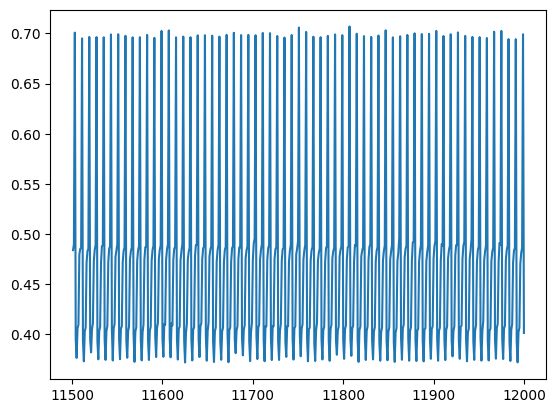

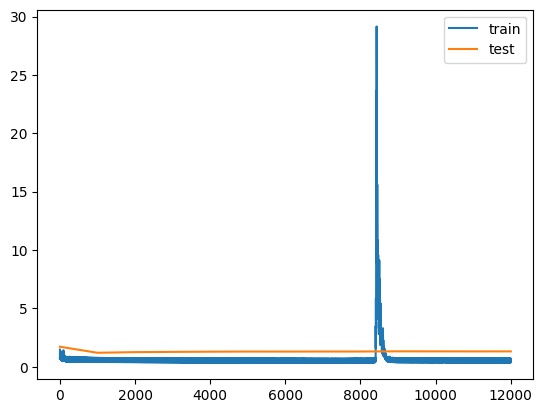

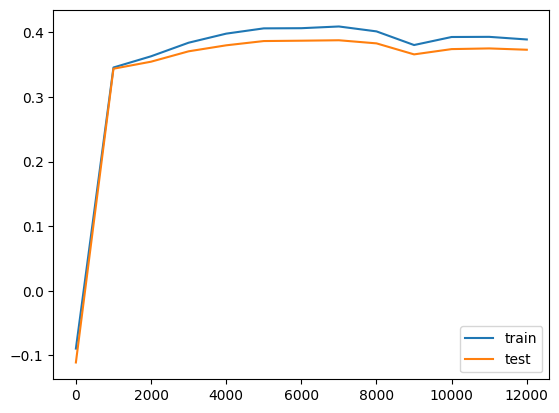

In [7]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [19]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([-0.0614,  0.0382,  0.0541, -0.0395, -0.1412,  0.0947, -0.0753,  0.0451,
         0.0889, -0.0264, -0.0923,  0.0926,  0.0201,  0.0646, -0.2211],
       device='cuda:0')
tensor([-0.0186, -0.1713, -0.0534, -0.1216, -0.0148,  0.0678, -0.0646, -0.0792,
         0.1374, -0.1338,  0.0144, -0.0022, -0.0586, -0.0244,  0.0698],
       device='cuda:0')


tensor([0.2145, 0.2050, 0.2313, 0.2340, 0.2276, 0.2446, 0.2486, 0.2399, 0.2598,
        0.2576], device='cuda:0')
------
------
tensor([-0.3305, -0.0021, -0.1763, -0.2279, -0.0876, -0.0553, -0.2489, -0.0788,
         0.1169,  0.1434], device='cuda:0') tensor([-0.2748, -0.0024, -0.1256, -0.3102, -0.0637, -0.0931, -0.4050, -0.1389,
         0.0964,  0.1549], device='cuda:0')
tensor([0.2360, 0.2271, 0.2695, 0.2519, 0.2177, 0.2641, 0.2474, 0.2499, 0.2577,
        0.2594], device='cuda:0')


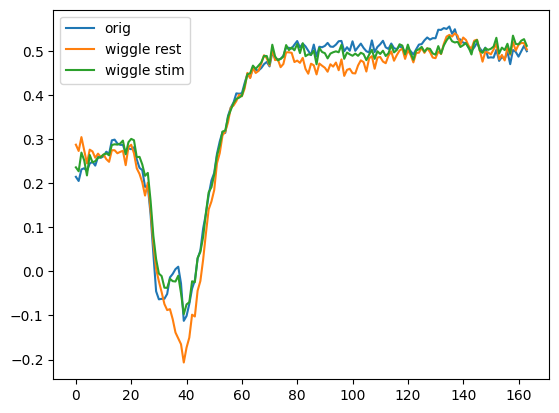

In [11]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]


def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * 1.2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

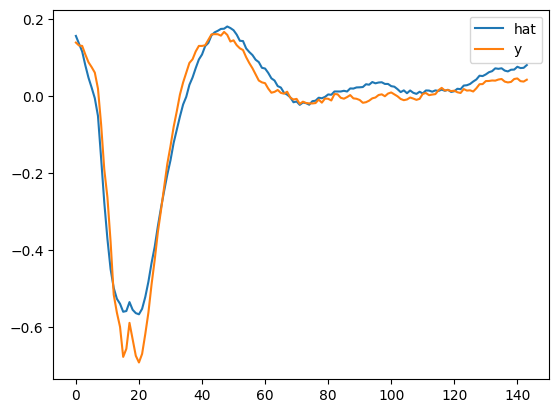

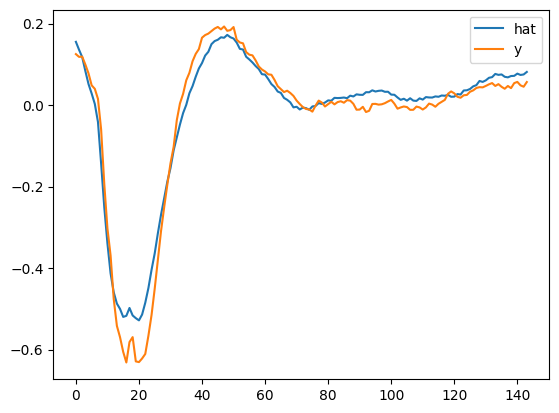

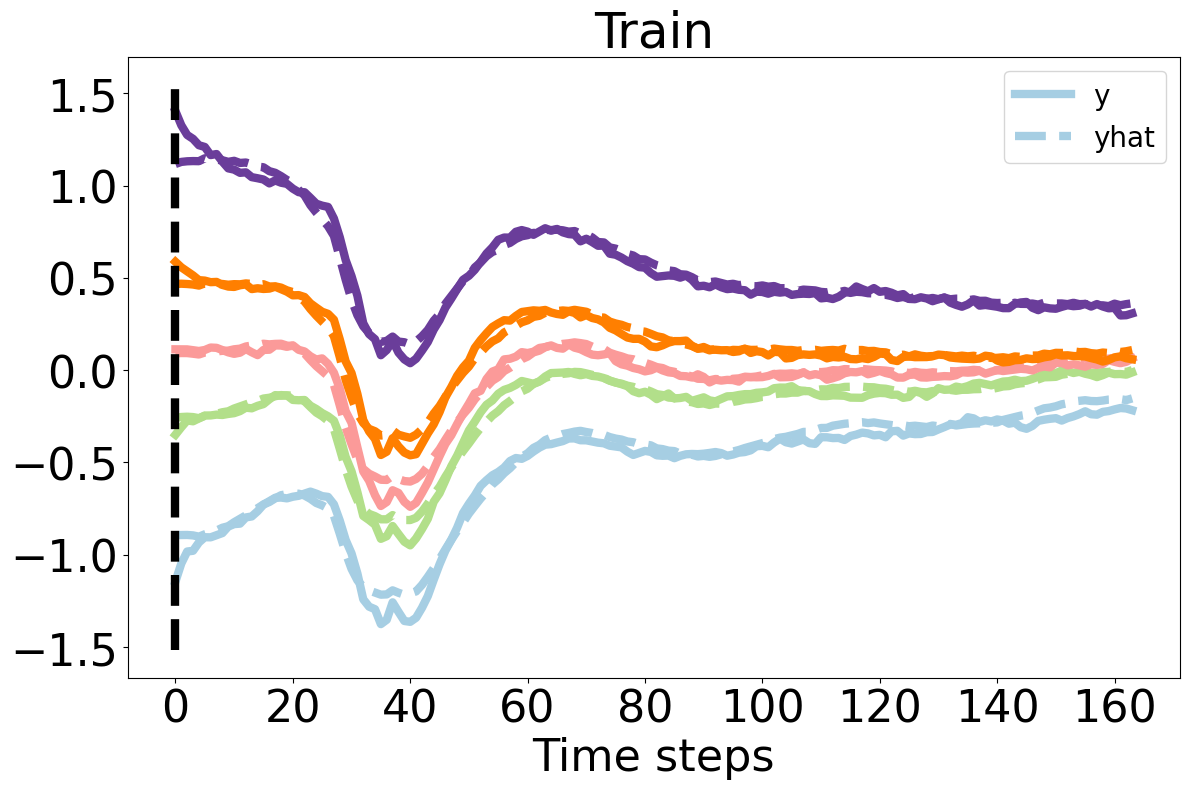

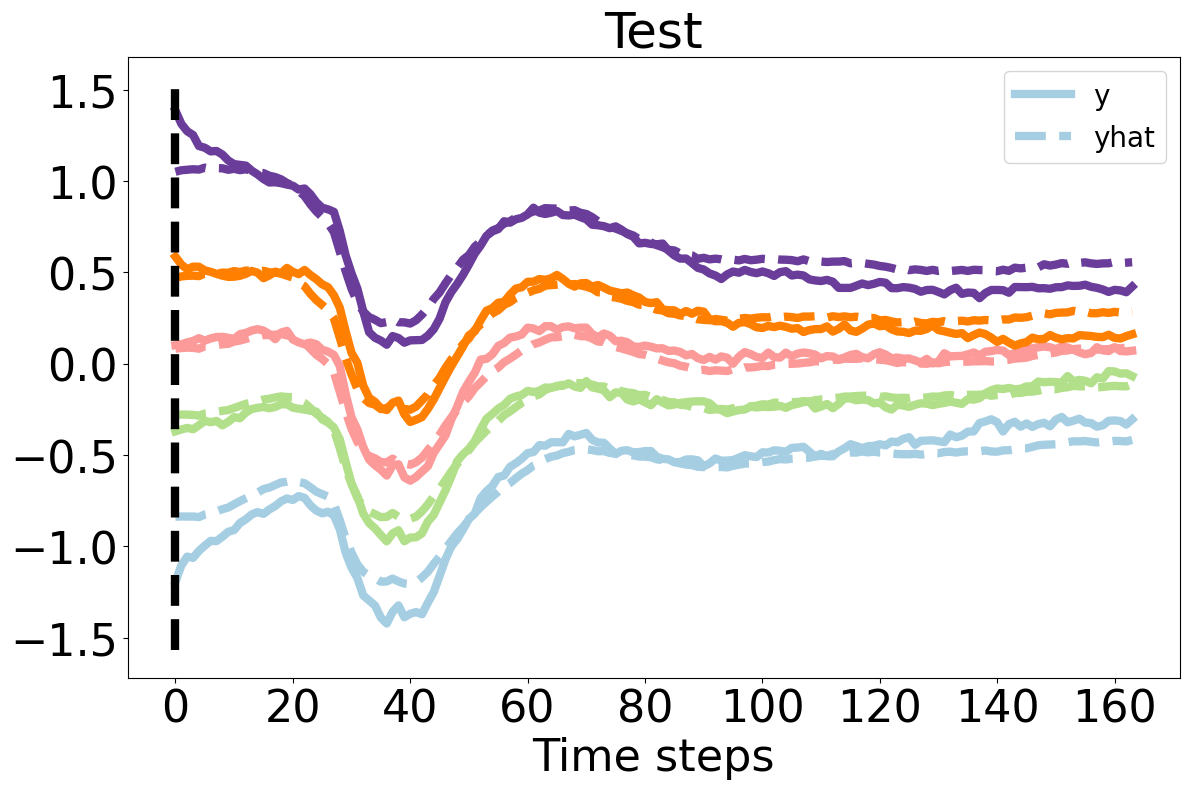

In [8]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)
    plt.show()
    
# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results, cidx=22)  # 10ms
# graph_for_sid('MonkeyG_20150917_Session1_M1', results, cidx=30)  # 10ms

graph_for_sid('MonkeyJ_20160426_Session2_S1', results, cidx=30)

# graph_for_sid('MonkeyG_20150918_Session1_M1', results)
# graph_for_sid('MonkeyG_20150915_Session3_S1', results)

In [ ]:
def graph_channels(sid, results):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)

    num_channels = y_hats.shape[-1]

    for cidx in range(num_channels):
        plt.plot(y_hat_mean[20:, cidx], label="hat")
        plt.plot(y_mean[20:, cidx], label="y")
        plt.legend()
        plt.title(f"{cidx} - Train")
        plt.show()
    
        plt.plot(y_hat_test_mean[20:, cidx], label="hat")
        plt.plot(y_test_mean[20:, cidx], label="y")
        plt.legend()
        plt.title(f"{cidx} - Test")
        plt.show()
    
# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results, cidx=22)  # 10ms
# graph_for_sid('MonkeyG_20150917_Session1_M1', results, cidx=30)  # 10ms

graph_channels('MonkeyJ_20160426_Session2_S1', results)

# graph_for_sid('MonkeyG_20150918_Session1_M1', results)
# graph_for_sid('MonkeyG_20150915_Session3_S1', results)

In [ ]:
# Try:
# cfg.tbfm.module.latent_dim = (16, 32, 64)
# cfg.tbfm.module.embed_dim_stim = (3, 7, 15, 20)

for latent_dim in (16, 32, 64):
    for embed_dim_stim in (3, 7, 15, 20):
        print("---------------", latent_dim, embed_dim_stim)

        # cfg.tbfm.training.lambda_fro = regweight
        # cfg.tbfm.module.num_bases = num_bases
        # cfg.training.grad_clip = grad_clip
        # cfg.latent_dim = latent_dimtrain_multisession_all2.ipynb
        # cfg.tbfm.training.optim.lr_head = lr_head
        # cfg.tbfm.training.lambda_ortho = lambda_ortho
        cfg.tbfm.module.latent_dim = latent_dim
        cfg.tbfm.module.embed_dim_stim = embed_dim_stim
        # cfg.tbfm.module.use_film_bases = True
        # cfg.ae.training.coadapt = True
        cfg.training.epochs = 15001

        ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
        model_optims = multisession.get_optims(cfg, ms)
        
        embeddings_stim, results = multisession.train_from_cfg(
            cfg,
            ms,
            data_train,
            model_optims,Carmen
            embeddings_rest,
            data_test=data_test,
            test_interval=5000,
            epochs=cfg.training.epochs,
            )
        torch.save(results, f"res_{latent_dim}_{embed_dim_stim}.torch")

        del model_optims, ms

--------------- 16 3
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1575546264648438 0.9233913421630859 0.0376604589788864 0.062086887657642365
---- 5000 0.5894997715950012 0.5439465641975403 0.4358087678750356 0.44218406081199646
---- 10000 0.5419514775276184 0.5320742130279541 0.48556982477506 0.4532109498977661


In [7]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)


# (0.4636920392513275, './res_2.0_15_0.1.torch')
# (0.463911235332489, './res_7.0_25_0.1.torch')
# (0.4639878273010254, './res_2.0_15_0.01.torch')
# (0.4647655487060547, './res_2.0_20_0.05.torch')Carmen
# (0.4657297134399414, './res_7.0_20_0.01.torch')
# (0.4676693379878998, './res_7.0_25_0.05.torch')
# (0.4676762521266937, './res_7.0_15_0.01.torch')
# (0.46845221519470215, './res_2.0_20_0.1.torch')
# (0.4699900150299072, './res_2.0_25_0.01.torch')
# (0.4754122197628021, './res_2.0_20_0.01.torch')

(0.4600786566734314, './res_64_15.torch')
(0.46490734815597534, './res_32_20.torch')
(0.4654322862625122, './res_64_7.torch')
(0.4656924605369568, './res_64_3.torch')
(0.46584925055503845, './res_16_3.torch')
(0.4660493731498718, './res_32_7.torch')
(0.467379093170166, './res_32_3.torch')
(0.46820545196533203, './res_16_7.torch')
(0.4695136547088623, './res_32_15.torch')
(0.4742690324783325, './res_16_15.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}


In [14]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=2000, data_test=data_test)
print(results_tta["final_test_r2s"])

TTA: Training data filtered: 29956/31250 trials kept
0 0.41692599654197693
100 0.397465318441391
200 0.39737945795059204
300 0.3972944915294647
400 0.3972620368003845
500 0.3972986042499542
600 0.3972949981689453
700 0.39720621705055237
800 0.3972524106502533
900 0.39725252985954285
1000 0.3973183035850525
1100 0.3971899449825287
1200 0.39721450209617615
1300 0.39724817872047424
1400 0.3972518742084503
1500 0.397227019071579
1600 0.3972472548484802
1700 0.39725321531295776
1800 0.39721301198005676
1900 0.39721760153770447
TTA: Test data filtered: 59945/62500 (95.9%)
{'MonkeyG_20150914_Session1_S1': 0.3470373600721359, 'MonkeyG_20150914_Session3_S1': 0.5071382969617844, 'MonkeyG_20150915_Session4_S1': 0.39404280483722687, 'MonkeyG_20150915_Session5_S1': 0.8304298520088196, 'MonkeyG_20150916_Session4_S1': 0.7099713385105133, 'MonkeyG_20150917_Session1_M1': 0.12506120651960373, 'MonkeyG_20150917_Session1_S1': 0.25299204140901566, 'MonkeyG_20150917_Session2_M1': 0.12339388951659203, 'Monke

Filtered 76 outlier trials
torch.Size([874, 164, 74]) torch.Size([1169, 164, 74]) torch.Size([874, 164, 74]) torch.Size([1169, 164, 74]) torch.Size([1169, 164, 74]) torch.Size([874, 164, 74])


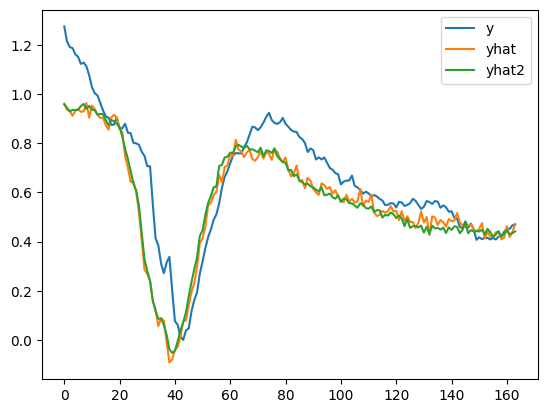

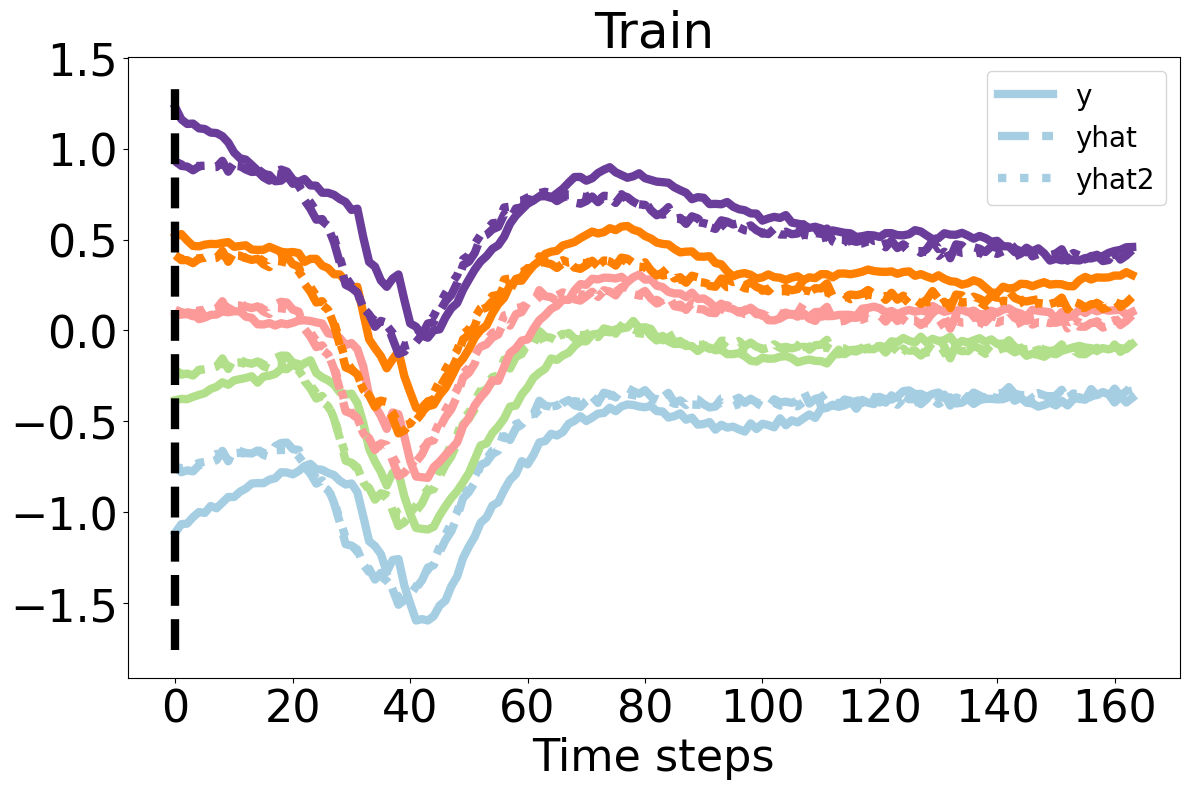

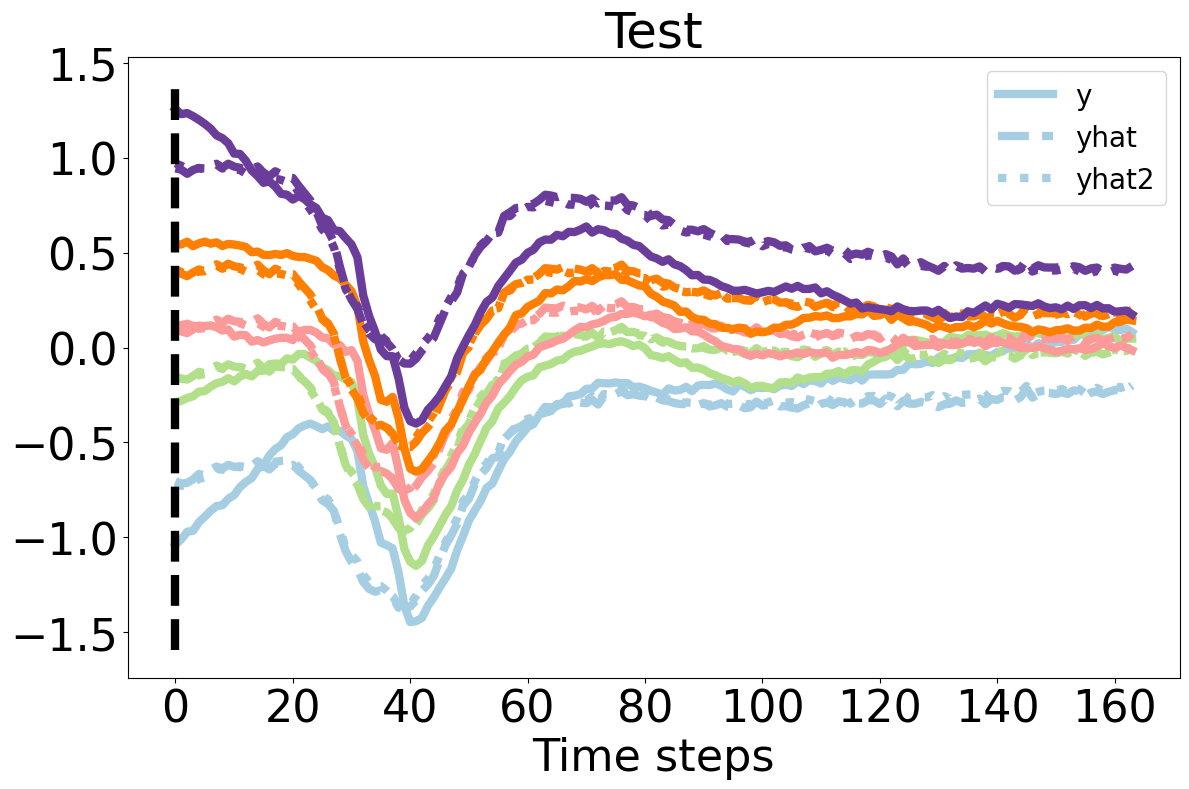

In [16]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)

        
        # Apply outlier filtering to match training behavior
        dt, filter_stats = utils.filter_batch_outliers(dt, model.norms, cfg)
        if cfg.training.use_outlier_filtering:
            print(f"Filtered {filter_stats['per_session'][sid][1] - filter_stats['per_session'][sid][0]} outlier trials")
            
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]
        
    print(y_hats.shape, y_hats_test.shape, y.shape, y_test.shape, y_hats_test2.shape, y_hats2.shape)

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

# graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid_tta('MonkeyJ_20160630_Session3_S1', results)
graph_for_sid_tta('MonkeyJ_20160426_Session3_S1', results, results_tta, data_train, ms, new_stim_embeddings)

